# Installation

In [1]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q transformers torchaudio moviepy pydub ipywidgets librosa wordcloud langdetect

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.8 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done


# Libraries

# Dataset

In [2]:
import os
import torch
import whisper
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter

from moviepy.editor import VideoFileClip
import ipywidgets as widgets

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch.nn.functional as F

from pydub import AudioSegment
from pydub.silence import split_on_silence
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
import langid

# Set seed for reproducibility
DetectorFactory.seed = 0

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# Set the path where your video(s) are stored
VIDEO_DIR = '/kaggle/input/car-video'
OUTPUT_DIR = '/kaggle/working/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# *** Part-1 ***

# Models

In [4]:
# Load Whisper model for speech-to-text (base version is fast and accurate)
whisper_model = whisper.load_model("base")

# Load sentiment analysis model (distilBERT fine-tuned on sentiment)
sentiment_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 82.4MiB/s]


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

# Utils-1

## Extract Audio from Video

In [5]:
def extract_audio_from_video(video_path, output_wav_path):
    """Extracts audio from video and saves it as a .wav file."""
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(output_wav_path, codec='pcm_s16le')

## Split Audio into 5-Second Chunks

In [6]:
def split_audio(audio_path, method="fixed", chunk_length_ms=5000, silence_thresh=-40, min_silence_len=700, keep_silence=300):
    audio = AudioSegment.from_wav(audio_path)
    chunks = []
    
    if method == "fixed":
        for i in range(0, len(audio), chunk_length_ms):
            chunk = audio[i:i+chunk_length_ms]
            chunks.append((chunk, i / 1000))  # Convert ms to seconds
    
    elif method == "silence":
        silence_chunks = split_on_silence(
            audio, 
            min_silence_len=min_silence_len, 
            silence_thresh=silence_thresh, 
            keep_silence=keep_silence
        )
        
        start_time = 0
        for chunk in silence_chunks:
            chunks.append((chunk, start_time / 1000))  # Convert ms to seconds
            start_time += len(chunk)
    
    else:
        raise ValueError("Invalid method. Choose 'fixed' or 'silence'.")
    
    return chunks


## Sentiment Analysis Function

In [7]:
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = sentiment_model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    pred_class = torch.argmax(probs).item()
    
    # Fine-grained sentiment mapping
    sentiment_map = {
        0: "Very Negative",   # 1-star
        1: "Negative",        # 2-star
        2: "Neutral",         # 3-star
        3: "Positive",        # 4-star
        4: "Very Positive"    # 5-star
    }

    return sentiment_map.get(pred_class, "Unknown")

# Main Function to Process a Single Video File

In [8]:
def process_video(video_path):
    print(f"Processing {video_path}")
    
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    temp_audio_path = f"{OUTPUT_DIR}/{video_name}.wav"
    
    # 1. Extract audio
    extract_audio_from_video(video_path, temp_audio_path)
    
    # 2. Chunk audio using fixed method
    audio_chunks_fixed = split_audio(temp_audio_path, method="fixed")
    results_fixed = process_chunks(audio_chunks_fixed)

    # Save results for fixed method to CSV
    df_fixed = pd.DataFrame(results_fixed)
    csv_filename_fixed = f"{video_name}_transcription_sentiment_fixed.csv"
    df_fixed.to_csv(os.path.join(OUTPUT_DIR, csv_filename_fixed), index=False)
    print(f"Saved CSV for fixed method to {os.path.join(OUTPUT_DIR, csv_filename_fixed)}")

    # 3. Chunk audio using silence method
    audio_chunks_silence = split_audio(temp_audio_path, method="silence")
    results_silence = process_chunks(audio_chunks_silence)

    # Save results for silence method to CSV
    df_silence = pd.DataFrame(results_silence)
    csv_filename_silence = f"{video_name}_transcription_sentiment_silence.csv"
    df_silence.to_csv(os.path.join(OUTPUT_DIR, csv_filename_silence), index=False)
    print(f"Saved CSV for silence method to {os.path.join(OUTPUT_DIR, csv_filename_silence)}")

def process_chunks(audio_chunks):
    results = []
    
    for idx, (chunk, start_sec) in enumerate(tqdm(audio_chunks)):
        chunk_path = f"{OUTPUT_DIR}/temp_chunk_{idx}.wav"
        chunk.export(chunk_path, format="wav")
        
        try:
            transcription = whisper_model.transcribe(chunk_path, fp16=False, language='en')
            text = transcription['text'].strip()
        except Exception as e:
            print(f"Error transcribing chunk {idx}: {e}")
            text = ""
        
        if text:
            sentiment = classify_sentiment(text)
            results.append({
                "chunk_id": idx,
                "start_time_sec": round(start_sec, 2),
                "transcription": text,
                "sentiment": sentiment
            })

        # Clean up chunk
        os.remove(chunk_path)
    
    return results

In [9]:
# Scan folder for all videos (supports multiple files)
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(VIDEO_DIR, video_file)
    process_video(video_path)


Processing /kaggle/input/car-video/Experimenter_CREW_999_1_All_1731617801.mp4
MoviePy - Writing audio in /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801.wav


MoviePy - Done.


100%|██████████| 72/72 [00:31<00:00,  2.27it/s]


Saved CSV for fixed method to /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_fixed.csv


100%|██████████| 72/72 [00:26<00:00,  2.71it/s]

Saved CSV for silence method to /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_silence.csv


In [10]:
# from IPython.display import Audio, display

# # Path to the audio file
# audio_path = '/kaggle/working/output/Experimenter_CREW_999_1_All_1731617801.wav'

# # Display the audio player
# display(Audio(filename=audio_path))

# *** Part-2 ***

# CSV file analysis

In [11]:
# Define the path to the CSV file generated in Part 1
CSV_PATH = "/kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_fixed.csv"

# Load the transcription data
df1 = pd.read_csv(CSV_PATH)

# Preview the data
df1.head()


,chunk_id,start_time_sec,transcription,sentiment
0,1,5.0,"Okay, so the",Neutral
1,2,10.0,you're going to complete and use the key autom...,Neutral
2,3,15.0,"operate vehicle, checking your needs off the s...",Very Positive
3,4,20.0,"Okay, so when you see that some driver indicat...",Neutral
4,5,25.0,drive. This dot the car cab look at will have ...,Positive


In [12]:
# Define the path to the CSV file generated in Part 1
CSV_PATH = "/kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_silence.csv"

# Load the transcription data
df2 = pd.read_csv(CSV_PATH)

# Preview the data
df2.head()


,chunk_id,start_time_sec,transcription,sentiment
0,0,0.00,Okay.,Neutral
1,1,1.26,"this, don't, the car can't work out.",Very Negative
2,2,2.57,You know everything.,Very Positive
3,3,3.22,Instructed.,Very Positive
4,4,3.84,45- Vielam arbic screwdriver.,Very Negative


# Utils-2

## 5-Second Buckets and Word Counts for Histogram

In [13]:
def generate_word_count_histogram(df):
    # Create a new column for the 5-second bucket
    df['time_bucket'] = df['start_time_sec'].apply(lambda x: f"{int(x // 5) * 5}-{int(x // 5) * 5 + 5}s")

    # Initialize dictionaries to hold word counts per bucket and store sentences
    bucket_word_counts = {}
    bucket_sentences = {}

    for _, row in df.iterrows():
        bucket = row['time_bucket']
        words = str(row['transcription']).split()
        sentence = str(row['transcription'])

        if bucket not in bucket_word_counts:
            bucket_word_counts[bucket] = 0
            bucket_sentences[bucket] = []  # List to hold sentences

        bucket_word_counts[bucket] += len(words)
        bucket_sentences[bucket].append(sentence)  # Store the sentence

    # Convert the word counts dictionary to a sorted DataFrame for plotting
    bucket_df = pd.DataFrame(list(bucket_word_counts.items()), columns=["Time Bucket", "Word Count"])
    bucket_df = bucket_df.sort_values(by="Time Bucket", key=lambda col: [int(i.split('-')[0]) for i in col])

    # Identify buckets with the maximum and minimum word counts
    max_count = bucket_df['Word Count'].max()
    min_count = bucket_df['Word Count'].min()

    max_bucket = bucket_df[bucket_df['Word Count'] == max_count]['Time Bucket'].values[0]
    min_bucket = bucket_df[bucket_df['Word Count'] == min_count]['Time Bucket'].values[0]
    
    max_sentences = bucket_sentences[max_bucket]
    min_sentences = bucket_sentences[min_bucket]

    # Print sentences for max and min counts with their time buckets
    print(f"Sentences for Max Count ({max_count}) in Bucket '{max_bucket}':")
    for sentence in max_sentences:
        print(f"- {sentence}")

    print(f"\nSentences for Min Count ({min_count}) in Bucket '{min_bucket}':")
    for sentence in min_sentences:
        print(f"- {sentence}")

    # Classify sentiments for the combined sentences in max and min buckets
    max_sentiment = classify_sentiment(" ".join(max_sentences))
    min_sentiment = classify_sentiment(" ".join(min_sentences))

    print(f"\nMax Count Sentiment: {max_sentiment}")
    print(f"Min Count Sentiment: {min_sentiment}")

    # Print sentiments for all sentences with word count >= 20 for additional insight
    # print("\nSentiments for sentences with word count >= 20:")
    # for bucket, sentences in bucket_sentences.items():
    #     for sentence in sentences:
    #         if len(sentence.split()) >= 20:
    #             sentiment = classify_sentiment(sentence)
    #             print(f"Bucket '{bucket}': '{sentence}' - Sentiment: {sentiment}")

    # Calculate overall sentiment for each bucket by combining all sentences
    bucket_sentiments = []
    for bucket in bucket_df['Time Bucket']:
        sentences = bucket_sentences[bucket]
        if sentences:
            combined_sentences = " ".join(sentences)
            sentiment = classify_sentiment(combined_sentences)
            bucket_sentiments.append(sentiment)
        else:
            bucket_sentiments.append("Neutral")  # Default to neutral if no sentences

    # Map fine-grained sentiments to colors:
    colors = []
    for sentiment in bucket_sentiments:
        if sentiment == "Very Negative":
            colors.append('darkred')
        elif sentiment == "Negative":
            colors.append('lightcoral')  # Light Red
        elif sentiment == "Positive":
            colors.append('lightblue')  # Light Blue
        elif sentiment == "Very Positive":
            colors.append('darkblue')
        else:
            colors.append('lightgray')  # Neutral

    # Plot the histogram
    plt.figure(figsize=(14, 6))
    bar_plot = sns.barplot(x="Time Bucket", y="Word Count", data=bucket_df, palette=colors)
    plt.xticks(rotation=45)
    plt.title("Word Count per 5-Second Time Bucket")
    plt.xlabel("Time Interval (s)")
    plt.ylabel("Word Count")

    # Annotate each bar with its word count
    for index, row in bucket_df.iterrows():
        bar_plot.annotate(row['Word Count'],
                          (index, row['Word Count']),
                          ha='center',
                          va='bottom')

    plt.tight_layout()

    # Create a legend for sentiment colors
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Very Positive', markerfacecolor='darkblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Positive', markerfacecolor='lightblue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Negative', markerfacecolor='lightcoral', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Very Negative', markerfacecolor='darkred', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Neutral', markerfacecolor='lightgray', markersize=10)
    ]
    plt.legend(handles=handles, loc='upper right', title='Sentiment')
    plt.show()

## Sentiment Classification Plot

In [14]:
def generate_sentiment_plot(df):
    # Define expected sentiment order and colors
    sentiment_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
    
    color_map = {
        "Very Negative": "darkred",
        "Negative": "orange",
        "Neutral": "gray",
        "Positive": "lightblue",
        "Very Positive": "darkblue"
    }

    # Count occurrences of each sentiment, ensuring all categories are present
    sentiment_counts = df['sentiment'].value_counts().reindex(sentiment_order, fill_value=0).reset_index()
    sentiment_counts.columns = ['Sentiment', 'Count']

    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bar_plot = sns.barplot(
        x="Sentiment", y="Count", data=sentiment_counts, 
        palette=[color_map[sent] for sent in sentiment_counts["Sentiment"]]
    )
    
    # Add title and labels
    plt.title("Distribution of Sentiment Classifications")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Segments")

    # Annotate the bars with their respective counts
    for p in bar_plot.patches:
        bar_plot.annotate(f'{int(p.get_height())}', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', 
                          fontsize=10, color='black', 
                          xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()  # Display the plot

    # Print one meaningful sentence for each sentiment category (choosing the longest)
    print("\nExample Sentences for Each Sentiment:")
    for sentiment in sentiment_order:
        sentences = df[df['sentiment'] == sentiment]
        if not sentences.empty:
            # Create a new column for the length of the transcription
            sentences['transcription_length'] = sentences['transcription'].str.len()
            # Sort by the length of the transcription and get the longest one
            longest_sentence = sentences.loc[sentences['transcription_length'].idxmax()]
            print(f"{sentiment} Sentence: {longest_sentence['transcription']}")
        else:
            print(f"No {sentiment} sentences available.")

## wordcloud

In [15]:
def generate_sentiment_wordclouds(df):
    # Define expected sentiment order
    sentiment_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    # Create a figure to hold the subplots
    plt.figure(figsize=(15, 10))

    for i, sentiment in enumerate(sentiment_order):
        # Filter the DataFrame for the current sentiment
        sentiment_texts = df[df['sentiment'] == sentiment]['transcription']
        
        # Join all the texts into a single string
        text = ' '.join(sentiment_texts)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Create a subplot for each sentiment
        ax = plt.subplot(2, 3, i + 1)  # Adjust the grid size as needed
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Turn off axis
        plt.title(f'Word Cloud for {sentiment}')

        # Add border to the subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Set border color
            spine.set_linewidth(2)  # Set border width

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the word clouds


## Detect language

In [16]:
def detect_language(text):
    """
    Detects the language of a given text using both langid and langdetect,
    then selects the most common prediction.
    """
    text = str(text).strip()
    if len(text.split()) < 3:  # Ignore very short texts
        return "unknown"

    # Get predictions from both models
    lang1 = langid.classify(text)[0]  
    try:
        lang2 = detect(text)
    except:
        lang2 = "unknown"  # Handle errors

    # Take the most frequent prediction
    detected_lang = Counter([lang1, lang2]).most_common(1)[0][0]
    return detected_lang

def detect_languages_in_df(df, text_column="transcription"):
    """
    Applies language detection to all rows in a DataFrame and prints a sample sentence per detected language.
    """
    df["language"] = df[text_column].apply(detect_language)

    # Print one example per unique detected language
    print("\nSample text for each detected language:\n")
    for lang in df["language"].unique():
        if lang == "unknown":
            continue
        example_text = df[df["language"] == lang][text_column].iloc[0]  # Get first example
        print(f"🔹 **{lang.upper()}**: {example_text}\n")

    return df

# Result

Sentences for Max Count (22) in Bucket '20-25s':
- Okay, so when you see that some driver indicator highlight green make sure you don't hit the brake at any point during

Sentences for Min Count (1) in Bucket '65-70s':
- .

Max Count Sentiment: Neutral
Min Count Sentiment: Neutral


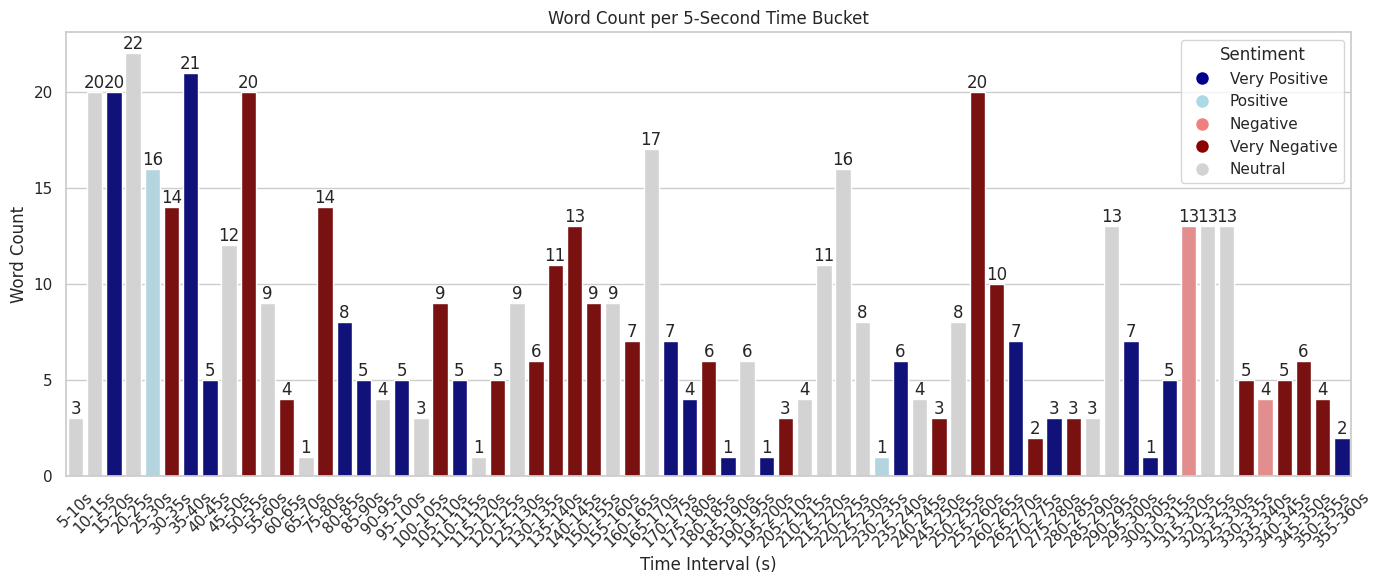

In [17]:
generate_word_count_histogram(df1)

Sentences for Max Count (30) in Bucket '65-70s':
- No, you won't see anything, but that I should see something.
- in the past.
- Sympos November 24, 2018 The century or For
- It should be a wide car right now.

Sentences for Min Count (4) in Bucket '70-75s':
- It's white xcv current.

Max Count Sentiment: Neutral
Min Count Sentiment: Neutral


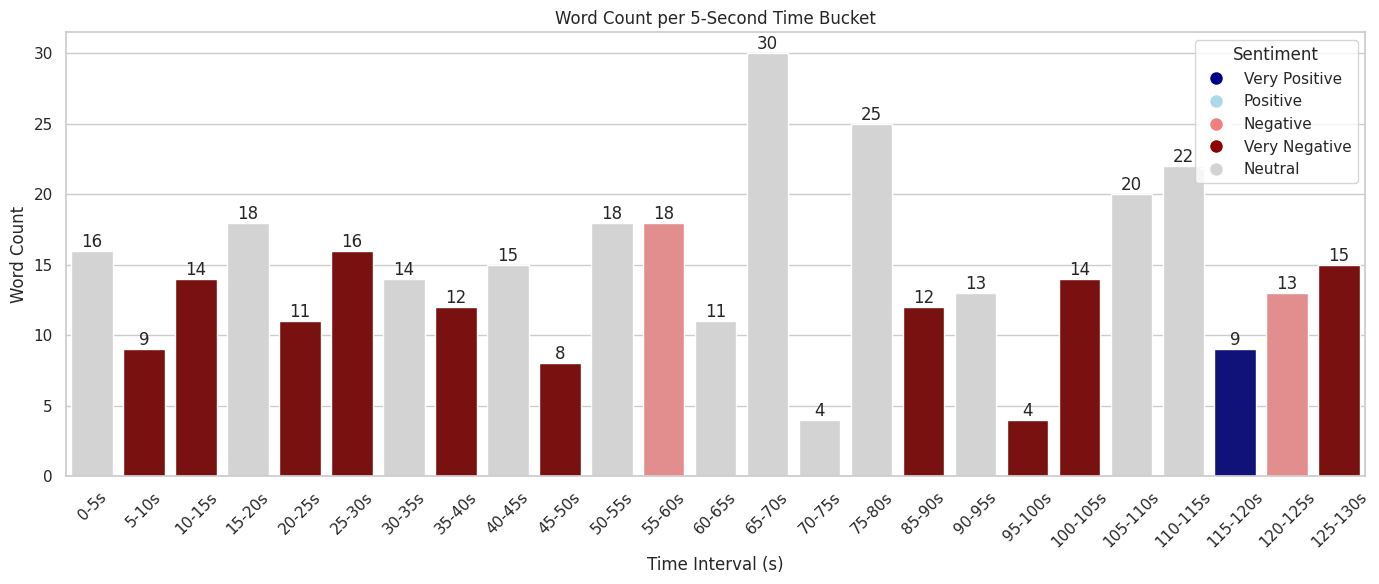

In [18]:
generate_word_count_histogram(df2)

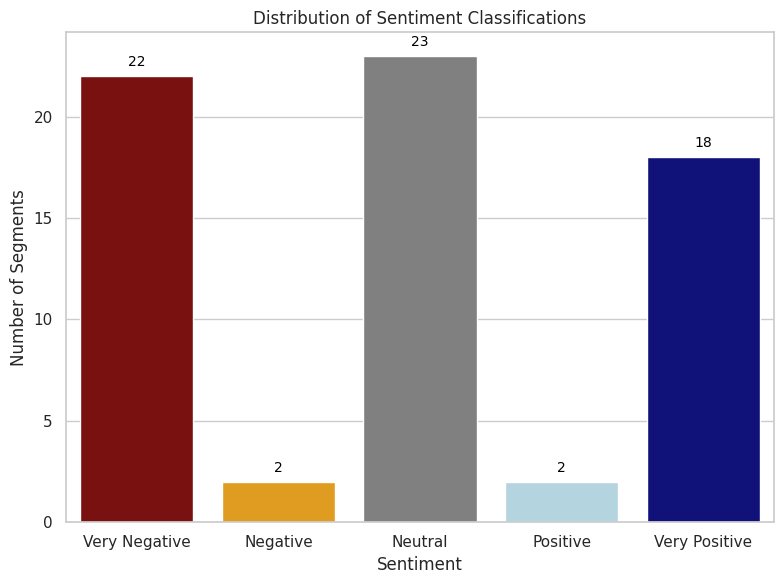


Example Sentences for Each Sentiment:
Very Negative Sentence: your foot from the brake until I instruct you to remove it or cap driver you may start the car.
Negative Sentence: you enough to understand or do you want to continue? Yeah I think
Neutral Sentence: Okay, so when you see that some driver indicator highlight green make sure you don't hit the brake at any point during
Positive Sentence: drive. This dot the car cab look at will have the hood yes for getting visual
Very Positive Sentence: operate vehicle, checking your needs off the steering wheel and head off the pedals, months before you get that drive.


In [19]:
generate_sentiment_plot(df1)

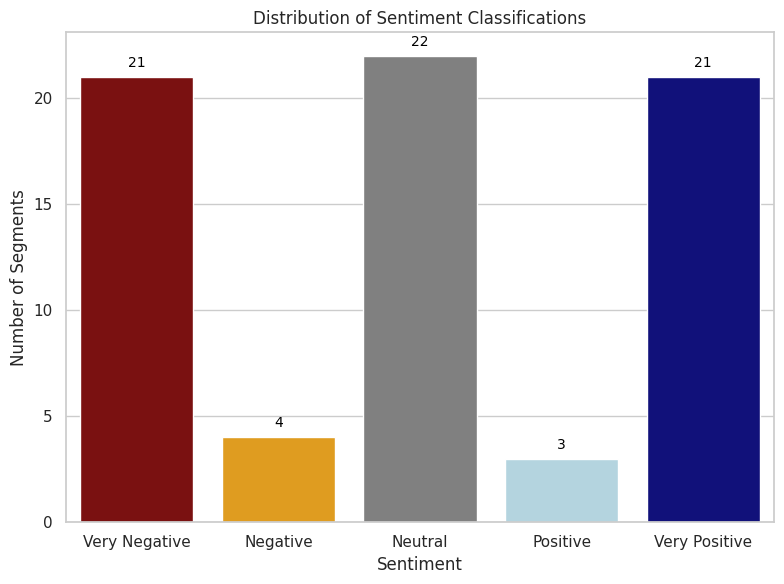


Example Sentences for Each Sentiment:
Very Negative Sentence: I'm a bad-ass ass, I'm a bad guy. I'm a bad guy. Passing now.
Negative Sentence: Ah, yeah, that's on the left side of the road.
Neutral Sentence: I think he's enough. I mean I'm having fun but we can stop if you want to.
Positive Sentence: passing military checkpoint.
Very Positive Sentence: Do you feel like this has given you enough to understand or do you want to?


In [20]:
generate_sentiment_plot(df2)

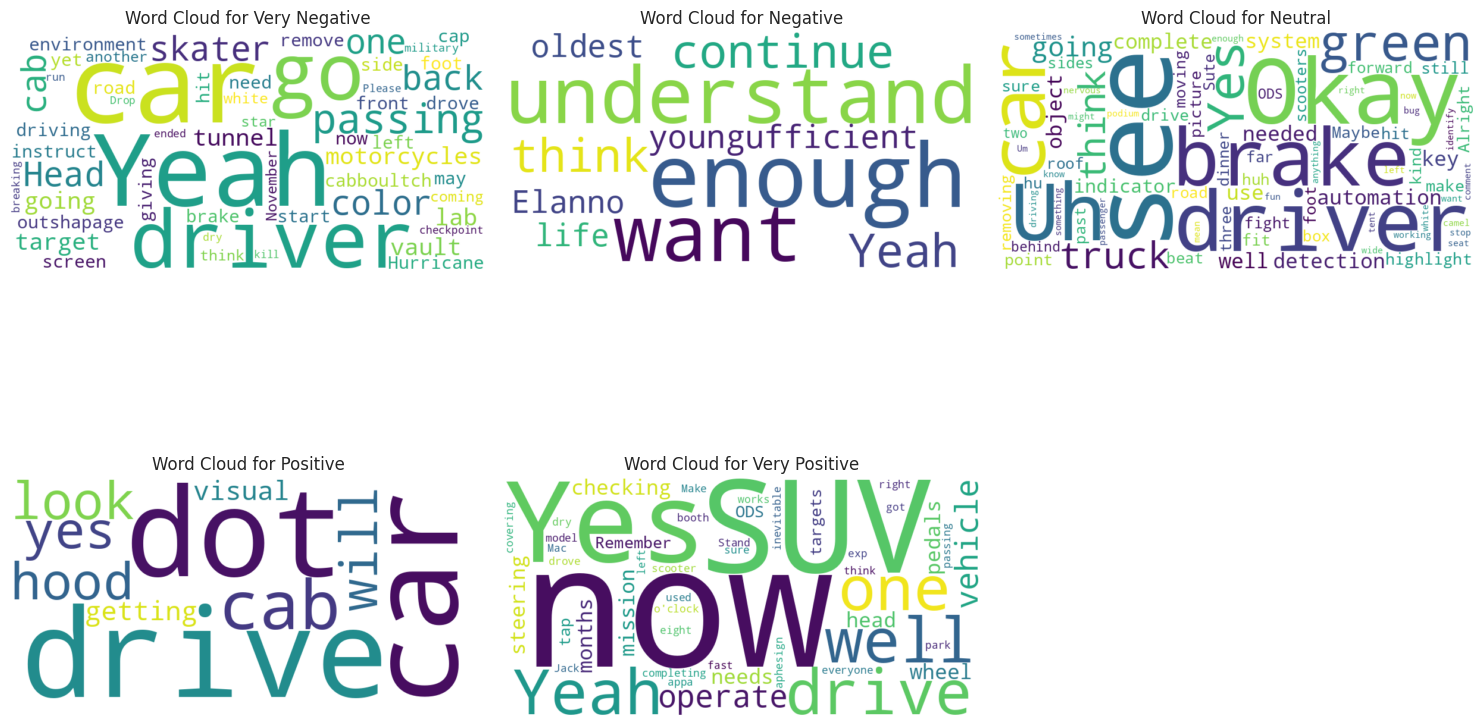

In [21]:
generate_sentiment_wordclouds(df1)

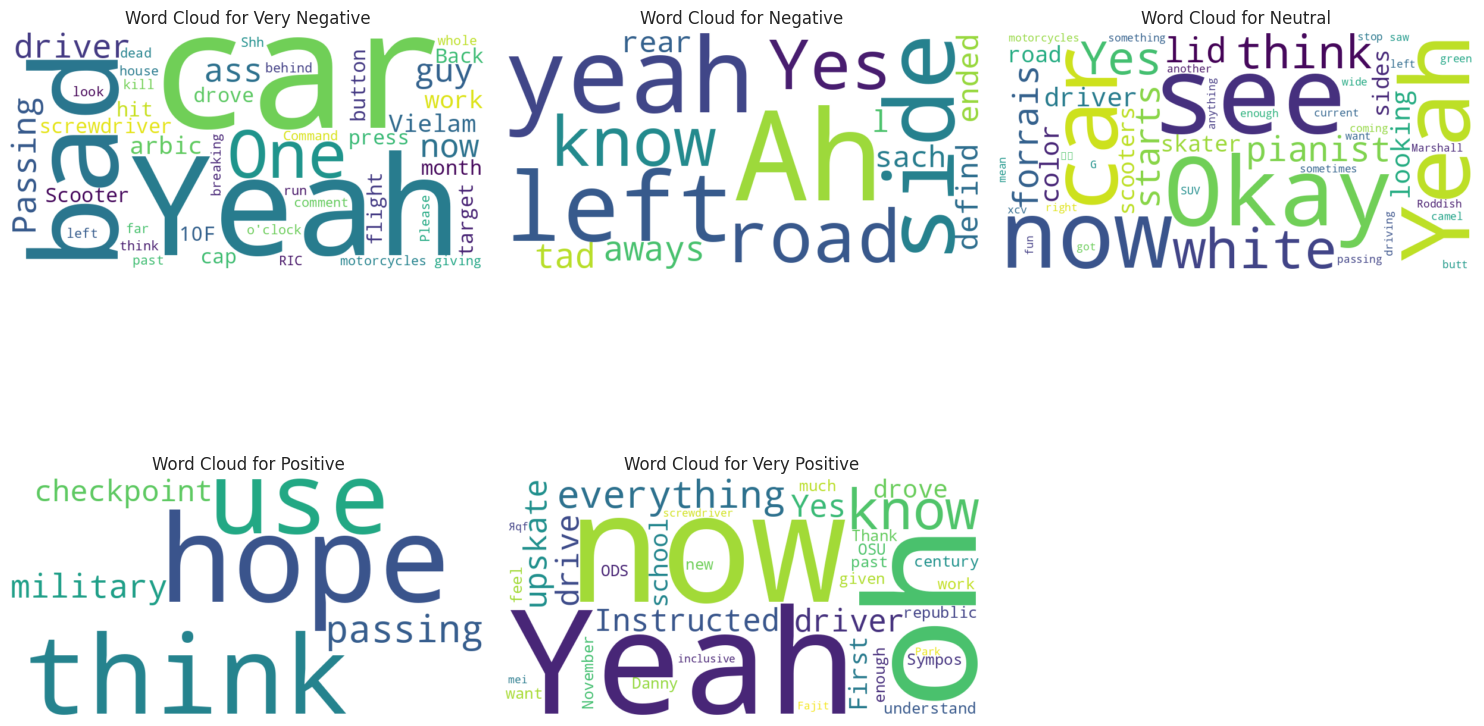

In [22]:
generate_sentiment_wordclouds(df2)

In [23]:
detect_languages_in_df(df1)


Sample text for each detected language:

🔹 **EN**: Okay, so the

🔹 **DE**: I am now in drive.

🔹 **ET**: I $appa aphesign now

🔹 **XH**: youngufficient oldest Elanno life



,chunk_id,start_time_sec,transcription,sentiment,time_bucket,language
0,1,5.0,"Okay, so the",Neutral,5-10s,en
1,2,10.0,you're going to complete and use the key autom...,Neutral,10-15s,en
2,3,15.0,"operate vehicle, checking your needs off the s...",Very Positive,15-20s,en
3,4,20.0,"Okay, so when you see that some driver indicat...",Neutral,20-25s,en
4,5,25.0,drive. This dot the car cab look at will have ...,Positive,25-30s,en
...,...,...,...,...,...,...
62,67,335.0,youngufficient oldest Elanno life,Negative,335-340s,xh
63,68,340.0,Drop it into breaking down.,Very Negative,340-345s,en
64,69,345.0,Please don't run through me. No.,Very Negative,345-350s,en
65,70,350.0,We've been we're ended,Very Negative,350-355s,en


In [24]:
detect_languages_in_df(df2)


Sample text for each detected language:

🔹 **EN**: this, don't, the car can't work out.

🔹 **IT**: One driver is...

🔹 **FR**: pianist starts forrais lid

🔹 **DE**: I am now in drive.

🔹 **PT**: I'm a bad-ass ass, I'm a bad guy. I'm a bad guy. Passing now.

🔹 **AR**: G می I Marshall Roddish

🔹 **ZH**: Fajit Яqf mei



,chunk_id,start_time_sec,transcription,sentiment,time_bucket,language
0,0,0.00,Okay.,Neutral,0-5s,unknown
1,1,1.26,"this, don't, the car can't work out.",Very Negative,0-5s,en
2,2,2.57,You know everything.,Very Positive,0-5s,en
3,3,3.22,Instructed.,Very Positive,0-5s,unknown
4,4,3.84,45- Vielam arbic screwdriver.,Very Negative,0-5s,en
...,...,...,...,...,...,...
66,67,123.47,Please don't run through me. No!,Very Negative,120-125s,en
67,68,126.26,We've been rear-ended.,Negative,125-130s,en
68,69,127.54,"No, there is no whole house…",Very Negative,125-130s,en
69,70,128.98,in Park now.,Very Positive,125-130s,en


In [25]:
def eda(df):
    generate_word_count_histogram(df)
    generate_sentiment_plot(df)
    generate_sentiment_wordclouds(df)
    # detect_languages_in_df(df)

# Automated test case

In [26]:
import unittest

class TestProcessing(unittest.TestCase):
    
    def setUp(self):
        # This method will run before each test
        self.transcript_text = "This is a sample transcription."  # Example transcription
        self.fixed_chunks = ["chunk1", "chunk2"]  # Example fixed chunks
        self.silence_chunks = ["chunkA", "chunkB"]  # Example silence chunks

    def test_transcription_not_empty(self):
        self.assertTrue(len(self.transcript_text) > 0, "Transcription should not be empty.")

    def test_sentiment_analysis(self):
        sentiment = classify_sentiment("This is a great test!")
        self.assertIn(sentiment, ["Very Positive", "Positive", "Neutral", "Negative", "Very Negative"], 
                        "Sentiment should be one of the expected values.")

    def test_chunking_methods(self):
        # Here you would typically call the process_video function to get the actual chunks
        # For example:
        # self.fixed_chunks, self.silence_chunks = process_video("path_to_video")
        
        # For testing purposes, we will use the predefined chunks
        self.assertTrue(len(self.fixed_chunks) > 0, "Fixed chunks should not be empty.")
        self.assertTrue(len(self.silence_chunks) > 0, "Silence chunks should not be empty.")

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)

test_chunking_methods (__main__.TestProcessing) ... ok
test_sentiment_analysis (__main__.TestProcessing) ... ok
test_transcription_not_empty (__main__.TestProcessing) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.060s

OK


# Simple User interactivity

In [27]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q transformers torchaudio moviepy pydub ipywidgets librosa wordcloud langdetect

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
import os
import torch
import whisper
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter

from moviepy.editor import VideoFileClip
import ipywidgets as widgets

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch.nn.functional as F

from pydub import AudioSegment
from pydub.silence import split_on_silence
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
import langid

# Set seed for reproducibility
DetectorFactory.seed = 0

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [29]:
# Load Whisper model for speech-to-text (base version is fast and accurate)
whisper_model = whisper.load_model("base")

# Load sentiment analysis model (distilBERT fine-tuned on sentiment)
sentiment_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

In [30]:
from carvideo_util import process_video, eda

# Set the path where your video(s) are stored
VIDEO_DIR = '/kaggle/input/car-video'
OUTPUT_DIR = '/kaggle/working/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Scan folder for all videos (supports multiple files)
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(VIDEO_DIR, video_file)
    process_video(video_path, whisper_model, tokenizer, sentiment_model)
    

Processing /kaggle/input/car-video/Experimenter_CREW_999_1_All_1731617801.mp4
MoviePy - Writing audio in /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801.wav


MoviePy - Done.


100%|██████████| 72/72 [00:31<00:00,  2.25it/s]


Saved CSV for fixed method to /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_fixed.csv


100%|██████████| 72/72 [00:35<00:00,  2.04it/s]

Saved CSV for silence method to /kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_silence.csv


In [31]:
# fixed chunking
CSV_PATH = "/kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_fixed.csv"
df1 = pd.read_csv(CSV_PATH)
df1.head()

,chunk_id,start_time_sec,transcription,sentiment
0,1,5.0,"Okay, so the",Neutral
1,2,10.0,you're going to complete and use the key autom...,Neutral
2,3,15.0,"operate vehicle, checking your needs off the s...",Very Positive
3,4,20.0,"Okay, so when you see that some driver indicat...",Neutral
4,5,25.0,drive. This dot the car cab look at will have ...,Positive


Sentences for Max Count (32) in Bucket '40-45s':
- Park, right. Oh, Ford. Probably won't get any attack here. I guarantee it will never be held inside the Hells! Once the gelecekers can be ready, don't melt, or I might stop.

Sentences for Min Count (1) in Bucket '185-190s':
- when

Max Count Sentiment: Very Negative
Min Count Sentiment: Neutral


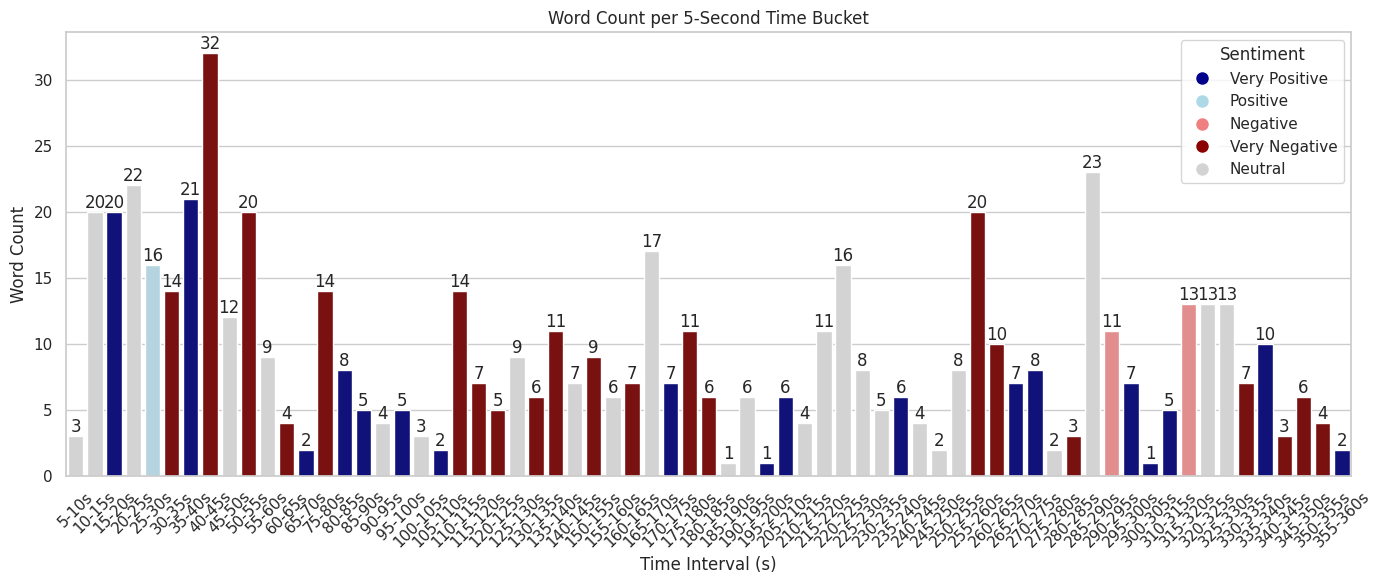

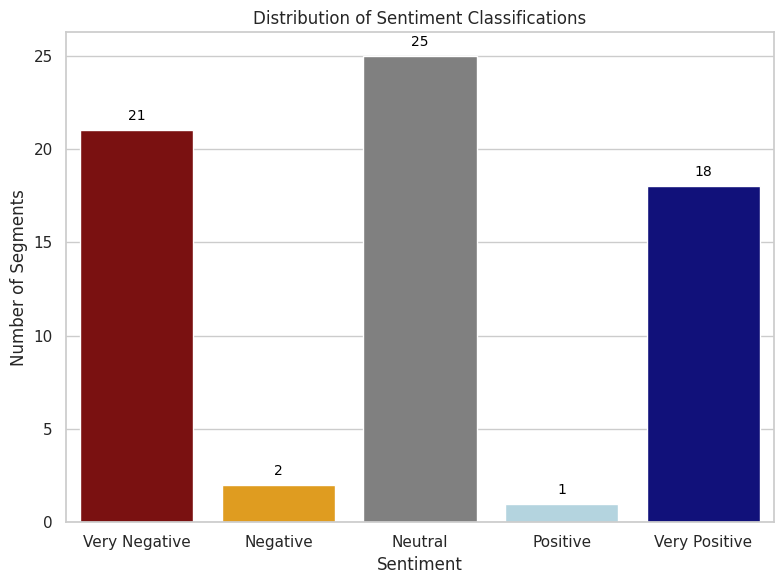


Example Sentences for Each Sentiment:
Very Negative Sentence: Park, right. Oh, Ford. Probably won't get any attack here. I guarantee it will never be held inside the Hells! Once the gelecekers can be ready, don't melt, or I might stop.
Negative Sentence: you enough to understand or do you want to continue? Yeah I think
Neutral Sentence: Let's know in a while, hopefully you are both fine! Alright let's see what happens up here And I didn't see there anything
Positive Sentence: drive. This dot the car cab look at will have the hood yes for getting visual
Very Positive Sentence: operate vehicle, checking your needs off the steering wheel and head off the pedals, months before you get that drive.


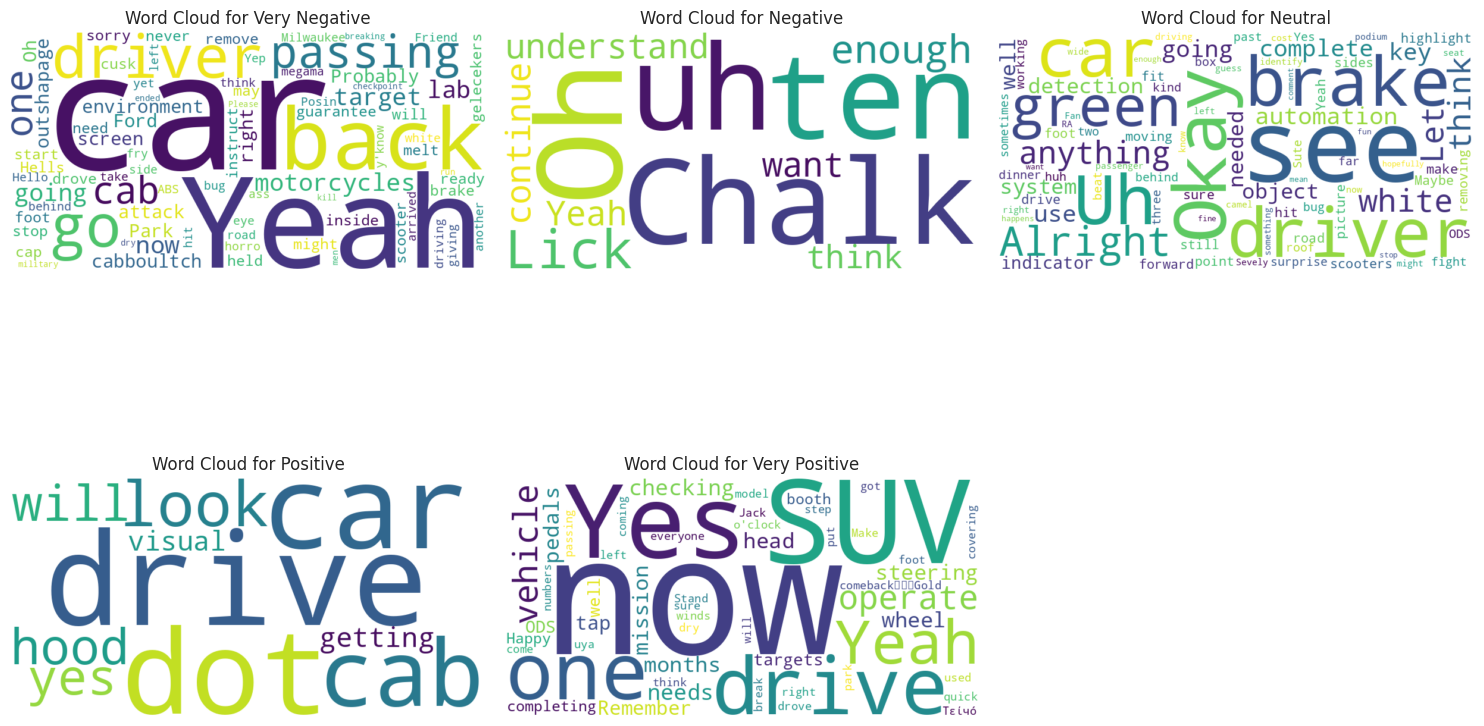

In [32]:
eda(df1, tokenizer, sentiment_model)

In [33]:
# silence chunking
CSV_PATH = "/kaggle/working/output/Experimenter_CREW_999_1_All_1731617801_transcription_sentiment_silence.csv"
df2 = pd.read_csv(CSV_PATH)
df2.head()

,chunk_id,start_time_sec,transcription,sentiment
0,1,5.0,"Okay, so the",Neutral
1,2,10.0,you're going to complete and use the key autom...,Neutral
2,3,15.0,"operate vehicle, checking your needs off the s...",Very Positive
3,4,20.0,"Okay, so when you see that some driver indicat...",Neutral
4,5,25.0,drive. This dot the car cab look at will have ...,Positive


Sentences for Max Count (34) in Bucket '110-115s':
- Because of all of thatimpression of your dead day, and you're alive! This on your own, your friends not justhosnig but you're like the first, last, and I was really busy with eyes noise

Sentences for Min Count (1) in Bucket '65-70s':
- Oh

Max Count Sentiment: Very Positive
Min Count Sentiment: Very Positive


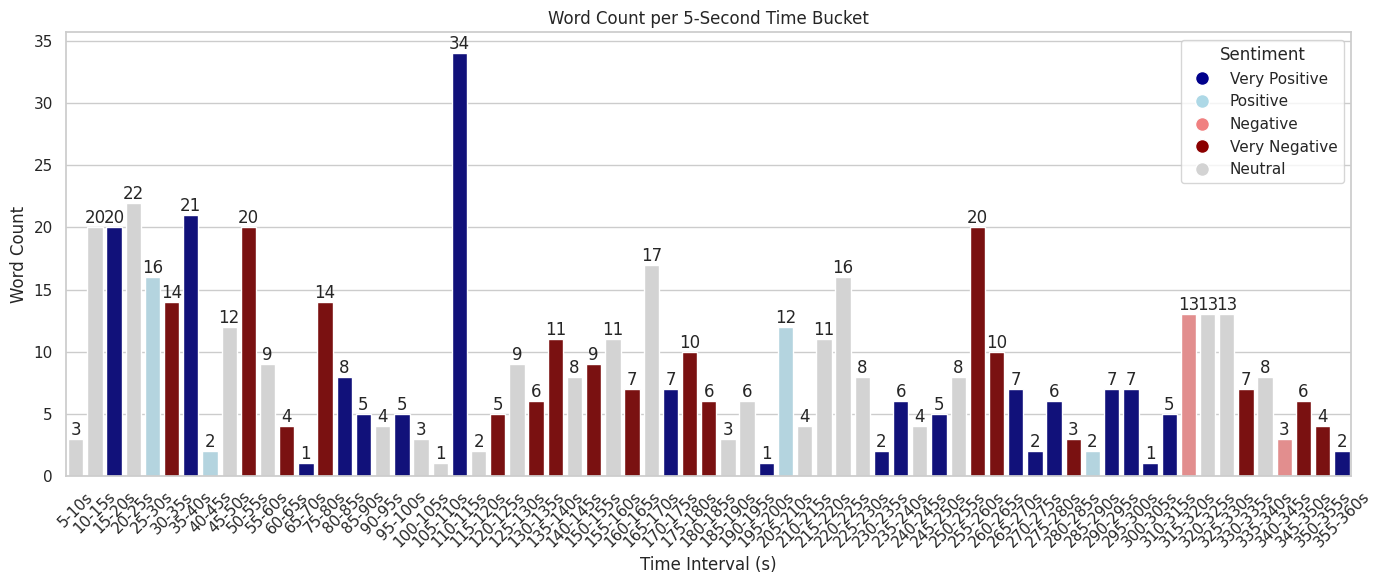

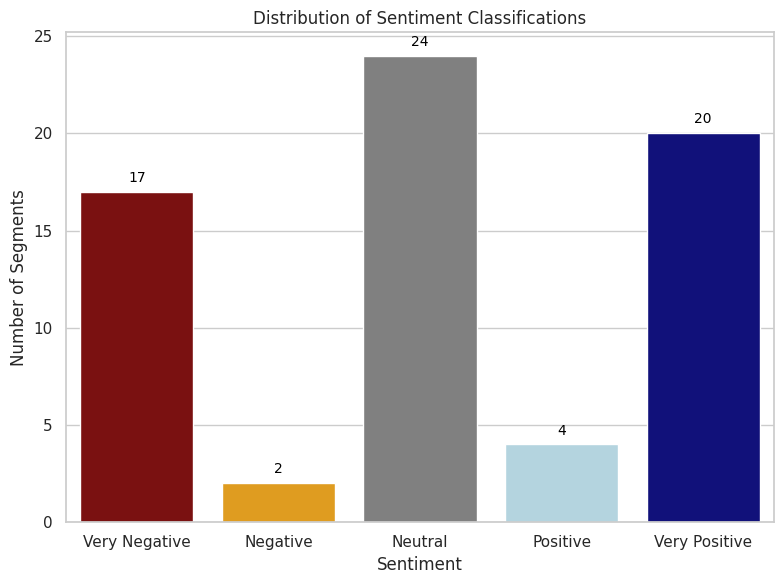


Example Sentences for Each Sentiment:
Very Negative Sentence: your foot from the brake until I instruct you to remove it or cap driver you may start the car.
Negative Sentence: you enough to understand or do you want to continue? Yeah I think
Neutral Sentence: Okay, so when you see that some driver indicator highlight green make sure you don't hit the brake at any point during
Positive Sentence: drive. This dot the car cab look at will have the hood yes for getting visual
Very Positive Sentence: Because of all of thatimpression of your dead day, and you're alive! This on your own, your friends not justhosnig but you're like the first, last, and I was really busy with eyes noise


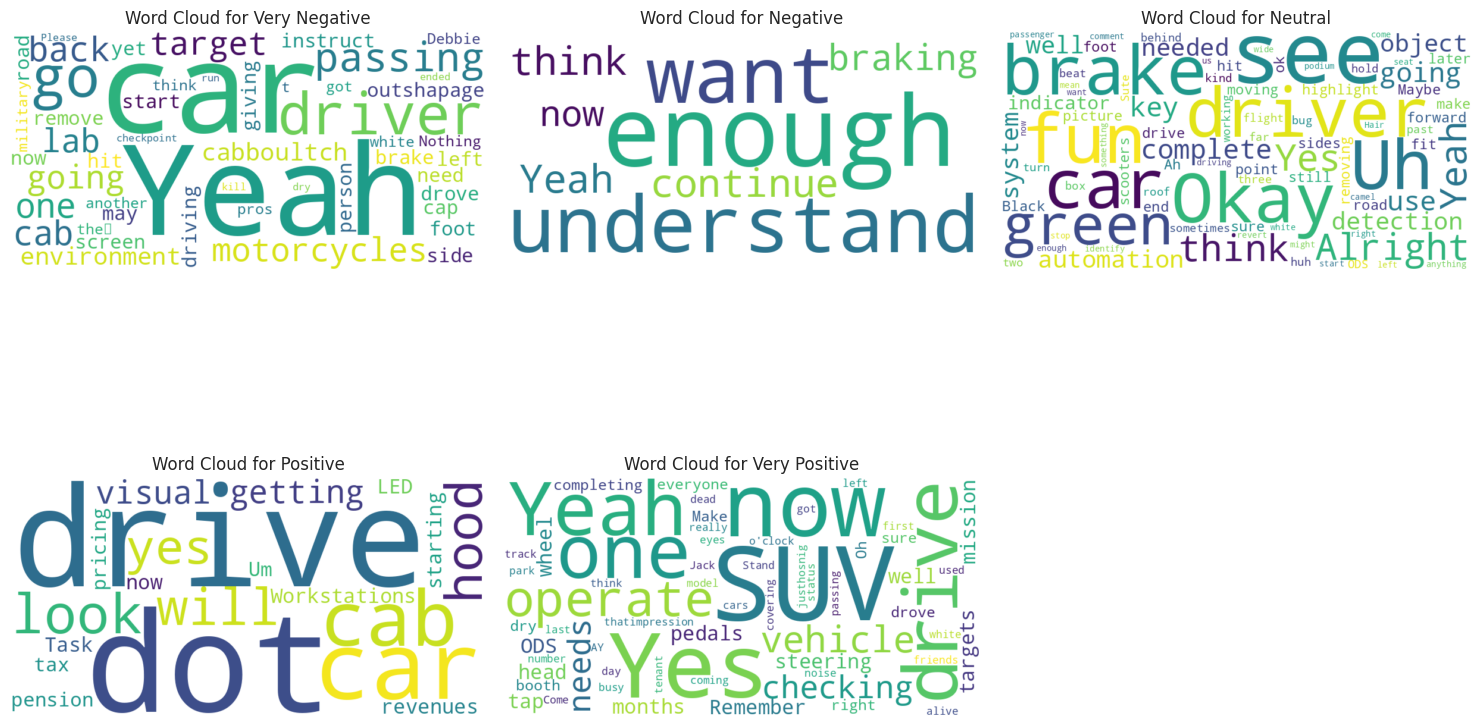

In [34]:
eda(df2, tokenizer, sentiment_model)